In [27]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")

In [41]:
# import inspect
# inspect.getfullargspec(PartialDependenceDisplay.from_estimator)
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

catboost==1.1.1
matplotlib==3.0.2
numpy==1.21.6
pandas==1.3.5
scikit-learn==1.0.2


In [40]:
# !python --version

In [17]:
# !pip show scikit-learn
# !pip install scikit-learn

In [ ]:
from platform import python_version

print(python_version())

In [2]:
import sys
import logging
import datetime

nblog = open("catboost_pdp_shap_"+str(datetime.datetime.now()).split(' ')[0]+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [4]:
%%time
df_localness = pd.read_csv('./food_localness_with_entropy_oct.csv')
print(df_localness.shape[0])

2887183


In [5]:
df_localness.head(2)

,account_id,order_id,order_date,order_time,vendor_id,vendor_name,main_cuisine,vertical,delivery_fee_amount_lc,service_fee_amount_lc,basket_amount_lc,is_incentive_applied,incentive_amount_lc,pickup_id,customer_lon,customer_lat,vendor_lon,vendor_lat,order_time_hour,delivery_duration,total_duration,customer_geometry,vendor_geometry,order_distance_km,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,nearest_euc_distance,localness,customer_loc_id,entropy_3.6km,item_price,compensation,discounted delivery,free delivery,gem,item discount,menu discount,voucher wallet,appoxi_rent,entropy_2km,entropy_0.3km,isweekend
0,4285647,1305786978,2023-10-10,2023-10-10 18:37:22,15921,"312 , Al Sufouh 1",american,food,9.0,2.36,78.5,0,0.0,249215302.0,55.22939,25.164577,55.175844,25.107854,18,37,54,POINT (6148107.571623116 2895972.7784882844),POINT (6142146.858169098 2888997.883505384),9.174926,food,702934,american,"My Hot Dog, Jumeirah 3",55.221344,25.176179,1.684822,0.183633,55.2293925.164577,0.670995,26.679487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.209394,0.625864,0.000000,False
1,1349127,1305612765,2023-10-10,2023-10-10 16:02:54,702587,"Subz, Business Bay",american,food,5.0,2.34,78.0,True,30.0,249170878.0,55.27096,25.180780,55.269598,25.188222,16,10,32,POINT (6152735.122855392 2897965.761873224),POINT (6152583.494576982 2898881.161766449),0.927873,food,702037,american,"Burger Basics, Business Bay",55.275506,25.180872,0.506177,0.545524,55.2709625.18078,0.744623,37.650000,0.0,0.0,0.0,0.0,0.0,30.0,0.0,95.263292,0.753064,0.414145,False


In [12]:
# df_localness.dtypes

In [30]:
# df_localness["isweekend"] = df_localness["isweekend"].astype(str)
# df_localness["main_cuisine"] = df_localness["main_cuisine"].astype(str)

In [6]:
df_features = df_localness[['basket_amount_lc','item_price','order_time_hour','total_duration',
                            'appoxi_rent', 'entropy_3.6km','entropy_2km','entropy_0.3km',
                            'incentive_amount_lc','isweekend','main_cuisine']]

In [7]:
X = df_features
y = df_localness.localness

In [8]:
%%time
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [9]:
X_train.dtypes

basket_amount_lc       float64
item_price             float64
order_time_hour        int64  
total_duration         int64  
appoxi_rent            float64
entropy_3.6km          float64
entropy_2km            float64
entropy_0.3km          float64
incentive_amount_lc    float64
isweekend              bool   
main_cuisine           object 
dtype: object

In [10]:
import catboost as cb

train_dataset = cb.Pool(X_train, y_train, cat_features=['isweekend','main_cuisine'])
test_dataset = cb.Pool(X_test, y_test, cat_features=['isweekend','main_cuisine'])

In [11]:
%%time

print(datetime.datetime.now(),'*************** Start running CatBoostRegressor ***************')
regressor = cb.CatBoostRegressor(custom_metric= ['R2', 'RMSE'])
regressor.fit(train_dataset, eval_set=test_dataset)
print(datetime.datetime.now(),'*************** Done running CatBoostRegressor ***************')

2024-05-28 21:33:39.994919 *************** Start running CatBoostRegressor ***************
Learning rate set to 0.168217
0:	learn: 0.2907786	test: 0.2908534	best: 0.2908534 (0)	total: 308ms	remaining: 5m 7s
1:	learn: 0.2823181	test: 0.2824234	best: 0.2824234 (1)	total: 498ms	remaining: 4m 8s
2:	learn: 0.2761396	test: 0.2762957	best: 0.2762957 (2)	total: 672ms	remaining: 3m 43s
3:	learn: 0.2713822	test: 0.2715654	best: 0.2715654 (3)	total: 849ms	remaining: 3m 31s
4:	learn: 0.2677312	test: 0.2679295	best: 0.2679295 (4)	total: 1.03s	remaining: 3m 24s
5:	learn: 0.2648939	test: 0.2651025	best: 0.2651025 (5)	total: 1.21s	remaining: 3m 20s
6:	learn: 0.2627388	test: 0.2629322	best: 0.2629322 (6)	total: 1.38s	remaining: 3m 15s
7:	learn: 0.2610874	test: 0.2612943	best: 0.2612943 (7)	total: 1.54s	remaining: 3m 11s
8:	learn: 0.2597524	test: 0.2599577	best: 0.2599577 (8)	total: 1.71s	remaining: 3m 8s
9:	learn: 0.2586180	test: 0.2588285	best: 0.2588285 (9)	total: 1.91s	remaining: 3m 8s
10:	learn: 0.

92:	learn: 0.2458875	test: 0.2462488	best: 0.2462488 (92)	total: 19.5s	remaining: 3m 10s
93:	learn: 0.2458062	test: 0.2461657	best: 0.2461657 (93)	total: 19.7s	remaining: 3m 10s
94:	learn: 0.2457795	test: 0.2461416	best: 0.2461416 (94)	total: 19.9s	remaining: 3m 9s
95:	learn: 0.2457514	test: 0.2461122	best: 0.2461122 (95)	total: 20.2s	remaining: 3m 9s
96:	learn: 0.2457003	test: 0.2460618	best: 0.2460618 (96)	total: 20.4s	remaining: 3m 9s
97:	learn: 0.2456575	test: 0.2460170	best: 0.2460170 (97)	total: 20.6s	remaining: 3m 9s
98:	learn: 0.2455660	test: 0.2459213	best: 0.2459213 (98)	total: 20.8s	remaining: 3m 9s
99:	learn: 0.2455216	test: 0.2458744	best: 0.2458744 (99)	total: 21s	remaining: 3m 8s
100:	learn: 0.2454425	test: 0.2458026	best: 0.2458026 (100)	total: 21.3s	remaining: 3m 9s
101:	learn: 0.2453815	test: 0.2457479	best: 0.2457479 (101)	total: 21.5s	remaining: 3m 9s
102:	learn: 0.2453051	test: 0.2456688	best: 0.2456688 (102)	total: 21.7s	remaining: 3m 9s
103:	learn: 0.2452541	test

184:	learn: 0.2415042	test: 0.2419322	best: 0.2419322 (184)	total: 39.5s	remaining: 2m 53s
185:	learn: 0.2414765	test: 0.2419069	best: 0.2419069 (185)	total: 39.7s	remaining: 2m 53s
186:	learn: 0.2414376	test: 0.2418692	best: 0.2418692 (186)	total: 39.9s	remaining: 2m 53s
187:	learn: 0.2414001	test: 0.2418335	best: 0.2418335 (187)	total: 40.1s	remaining: 2m 53s
188:	learn: 0.2413710	test: 0.2418069	best: 0.2418069 (188)	total: 40.4s	remaining: 2m 53s
189:	learn: 0.2413146	test: 0.2417521	best: 0.2417521 (189)	total: 40.5s	remaining: 2m 52s
190:	learn: 0.2412922	test: 0.2417292	best: 0.2417292 (190)	total: 40.7s	remaining: 2m 52s
191:	learn: 0.2412672	test: 0.2417054	best: 0.2417054 (191)	total: 40.9s	remaining: 2m 52s
192:	learn: 0.2412271	test: 0.2416639	best: 0.2416639 (192)	total: 41.1s	remaining: 2m 52s
193:	learn: 0.2412094	test: 0.2416475	best: 0.2416475 (193)	total: 41.4s	remaining: 2m 51s
194:	learn: 0.2411673	test: 0.2416065	best: 0.2416065 (194)	total: 41.6s	remaining: 2m 51s

276:	learn: 0.2383574	test: 0.2388798	best: 0.2388798 (276)	total: 59.4s	remaining: 2m 35s
277:	learn: 0.2383297	test: 0.2388504	best: 0.2388504 (277)	total: 59.7s	remaining: 2m 34s
278:	learn: 0.2383144	test: 0.2388362	best: 0.2388362 (278)	total: 59.9s	remaining: 2m 34s
279:	learn: 0.2382692	test: 0.2387895	best: 0.2387895 (279)	total: 1m	remaining: 2m 34s
280:	learn: 0.2382298	test: 0.2387512	best: 0.2387512 (280)	total: 1m	remaining: 2m 34s
281:	learn: 0.2382099	test: 0.2387314	best: 0.2387314 (281)	total: 1m	remaining: 2m 34s
282:	learn: 0.2381495	test: 0.2386722	best: 0.2386722 (282)	total: 1m	remaining: 2m 34s
283:	learn: 0.2381239	test: 0.2386454	best: 0.2386454 (283)	total: 1m 1s	remaining: 2m 33s
284:	learn: 0.2380832	test: 0.2386038	best: 0.2386038 (284)	total: 1m 1s	remaining: 2m 33s
285:	learn: 0.2380642	test: 0.2385869	best: 0.2385869 (285)	total: 1m 1s	remaining: 2m 33s
286:	learn: 0.2380468	test: 0.2385715	best: 0.2385715 (286)	total: 1m 1s	remaining: 2m 33s
287:	learn:

366:	learn: 0.2358809	test: 0.2364727	best: 0.2364727 (366)	total: 1m 19s	remaining: 2m 16s
367:	learn: 0.2358495	test: 0.2364406	best: 0.2364406 (367)	total: 1m 19s	remaining: 2m 16s
368:	learn: 0.2358068	test: 0.2364029	best: 0.2364029 (368)	total: 1m 19s	remaining: 2m 16s
369:	learn: 0.2357926	test: 0.2363907	best: 0.2363907 (369)	total: 1m 19s	remaining: 2m 16s
370:	learn: 0.2357732	test: 0.2363706	best: 0.2363706 (370)	total: 1m 20s	remaining: 2m 16s
371:	learn: 0.2357444	test: 0.2363432	best: 0.2363432 (371)	total: 1m 20s	remaining: 2m 15s
372:	learn: 0.2357212	test: 0.2363197	best: 0.2363197 (372)	total: 1m 20s	remaining: 2m 15s
373:	learn: 0.2357011	test: 0.2363034	best: 0.2363034 (373)	total: 1m 20s	remaining: 2m 15s
374:	learn: 0.2356664	test: 0.2362661	best: 0.2362661 (374)	total: 1m 21s	remaining: 2m 15s
375:	learn: 0.2356458	test: 0.2362464	best: 0.2362464 (375)	total: 1m 21s	remaining: 2m 14s
376:	learn: 0.2356042	test: 0.2362058	best: 0.2362058 (376)	total: 1m 21s	remain

456:	learn: 0.2337591	test: 0.2344481	best: 0.2344481 (456)	total: 1m 38s	remaining: 1m 57s
457:	learn: 0.2337393	test: 0.2344281	best: 0.2344281 (457)	total: 1m 38s	remaining: 1m 56s
458:	learn: 0.2337088	test: 0.2344016	best: 0.2344016 (458)	total: 1m 39s	remaining: 1m 56s
459:	learn: 0.2336931	test: 0.2343886	best: 0.2343886 (459)	total: 1m 39s	remaining: 1m 56s
460:	learn: 0.2336830	test: 0.2343796	best: 0.2343796 (460)	total: 1m 39s	remaining: 1m 56s
461:	learn: 0.2336677	test: 0.2343638	best: 0.2343638 (461)	total: 1m 39s	remaining: 1m 56s
462:	learn: 0.2336521	test: 0.2343475	best: 0.2343475 (462)	total: 1m 39s	remaining: 1m 55s
463:	learn: 0.2336360	test: 0.2343333	best: 0.2343333 (463)	total: 1m 40s	remaining: 1m 55s
464:	learn: 0.2336182	test: 0.2343163	best: 0.2343163 (464)	total: 1m 40s	remaining: 1m 55s
465:	learn: 0.2335917	test: 0.2342919	best: 0.2342919 (465)	total: 1m 40s	remaining: 1m 55s
466:	learn: 0.2335763	test: 0.2342778	best: 0.2342778 (466)	total: 1m 40s	remain

546:	learn: 0.2321271	test: 0.2329019	best: 0.2329019 (546)	total: 1m 58s	remaining: 1m 38s
547:	learn: 0.2321016	test: 0.2328782	best: 0.2328782 (547)	total: 1m 58s	remaining: 1m 37s
548:	learn: 0.2320943	test: 0.2328720	best: 0.2328720 (548)	total: 1m 58s	remaining: 1m 37s
549:	learn: 0.2320510	test: 0.2328328	best: 0.2328328 (549)	total: 1m 59s	remaining: 1m 37s
550:	learn: 0.2320276	test: 0.2328089	best: 0.2328089 (550)	total: 1m 59s	remaining: 1m 37s
551:	learn: 0.2320126	test: 0.2327955	best: 0.2327955 (551)	total: 1m 59s	remaining: 1m 36s
552:	learn: 0.2319891	test: 0.2327695	best: 0.2327695 (552)	total: 1m 59s	remaining: 1m 36s
553:	learn: 0.2319648	test: 0.2327467	best: 0.2327467 (553)	total: 1m 59s	remaining: 1m 36s
554:	learn: 0.2319499	test: 0.2327303	best: 0.2327303 (554)	total: 2m	remaining: 1m 36s
555:	learn: 0.2319346	test: 0.2327147	best: 0.2327147 (555)	total: 2m	remaining: 1m 36s
556:	learn: 0.2319253	test: 0.2327051	best: 0.2327051 (556)	total: 2m	remaining: 1m 35s


637:	learn: 0.2303717	test: 0.2312052	best: 0.2312052 (637)	total: 2m 18s	remaining: 1m 18s
638:	learn: 0.2303586	test: 0.2311920	best: 0.2311920 (638)	total: 2m 18s	remaining: 1m 18s
639:	learn: 0.2303377	test: 0.2311763	best: 0.2311763 (639)	total: 2m 18s	remaining: 1m 18s
640:	learn: 0.2303254	test: 0.2311641	best: 0.2311641 (640)	total: 2m 18s	remaining: 1m 17s
641:	learn: 0.2302937	test: 0.2311327	best: 0.2311327 (641)	total: 2m 19s	remaining: 1m 17s
642:	learn: 0.2302812	test: 0.2311213	best: 0.2311213 (642)	total: 2m 19s	remaining: 1m 17s
643:	learn: 0.2302634	test: 0.2311045	best: 0.2311045 (643)	total: 2m 19s	remaining: 1m 17s
644:	learn: 0.2302500	test: 0.2310924	best: 0.2310924 (644)	total: 2m 19s	remaining: 1m 16s
645:	learn: 0.2302380	test: 0.2310801	best: 0.2310801 (645)	total: 2m 19s	remaining: 1m 16s
646:	learn: 0.2302217	test: 0.2310657	best: 0.2310657 (646)	total: 2m 20s	remaining: 1m 16s
647:	learn: 0.2301903	test: 0.2310355	best: 0.2310355 (647)	total: 2m 20s	remain

727:	learn: 0.2289684	test: 0.2298731	best: 0.2298731 (727)	total: 2m 38s	remaining: 59.2s
728:	learn: 0.2289455	test: 0.2298527	best: 0.2298527 (728)	total: 2m 38s	remaining: 58.9s
729:	learn: 0.2289248	test: 0.2298352	best: 0.2298352 (729)	total: 2m 38s	remaining: 58.7s
730:	learn: 0.2289112	test: 0.2298217	best: 0.2298217 (730)	total: 2m 39s	remaining: 58.5s
731:	learn: 0.2288996	test: 0.2298107	best: 0.2298107 (731)	total: 2m 39s	remaining: 58.3s
732:	learn: 0.2288873	test: 0.2297989	best: 0.2297989 (732)	total: 2m 39s	remaining: 58.1s
733:	learn: 0.2288672	test: 0.2297775	best: 0.2297775 (733)	total: 2m 39s	remaining: 57.9s
734:	learn: 0.2288326	test: 0.2297408	best: 0.2297408 (734)	total: 2m 40s	remaining: 57.7s
735:	learn: 0.2288093	test: 0.2297192	best: 0.2297192 (735)	total: 2m 40s	remaining: 57.5s
736:	learn: 0.2287933	test: 0.2297034	best: 0.2297034 (736)	total: 2m 40s	remaining: 57.2s
737:	learn: 0.2287846	test: 0.2296952	best: 0.2296952 (737)	total: 2m 40s	remaining: 57s
7

818:	learn: 0.2276272	test: 0.2286061	best: 0.2286061 (818)	total: 2m 58s	remaining: 39.4s
819:	learn: 0.2276124	test: 0.2285927	best: 0.2285927 (819)	total: 2m 58s	remaining: 39.2s
820:	learn: 0.2275989	test: 0.2285806	best: 0.2285806 (820)	total: 2m 58s	remaining: 39s
821:	learn: 0.2275948	test: 0.2285788	best: 0.2285788 (821)	total: 2m 58s	remaining: 38.8s
822:	learn: 0.2275875	test: 0.2285724	best: 0.2285724 (822)	total: 2m 59s	remaining: 38.5s
823:	learn: 0.2275692	test: 0.2285552	best: 0.2285552 (823)	total: 2m 59s	remaining: 38.3s
824:	learn: 0.2275532	test: 0.2285401	best: 0.2285401 (824)	total: 2m 59s	remaining: 38.1s
825:	learn: 0.2275302	test: 0.2285178	best: 0.2285178 (825)	total: 2m 59s	remaining: 37.9s
826:	learn: 0.2275251	test: 0.2285141	best: 0.2285141 (826)	total: 3m	remaining: 37.7s
827:	learn: 0.2275087	test: 0.2285015	best: 0.2285015 (827)	total: 3m	remaining: 37.5s
828:	learn: 0.2274960	test: 0.2284870	best: 0.2284870 (828)	total: 3m	remaining: 37.2s
829:	learn: 0

909:	learn: 0.2264803	test: 0.2275278	best: 0.2275278 (909)	total: 3m 18s	remaining: 19.7s
910:	learn: 0.2264691	test: 0.2275174	best: 0.2275174 (910)	total: 3m 19s	remaining: 19.4s
911:	learn: 0.2264572	test: 0.2275065	best: 0.2275065 (911)	total: 3m 19s	remaining: 19.2s
912:	learn: 0.2264342	test: 0.2274849	best: 0.2274849 (912)	total: 3m 19s	remaining: 19s
913:	learn: 0.2264263	test: 0.2274784	best: 0.2274784 (913)	total: 3m 19s	remaining: 18.8s
914:	learn: 0.2264118	test: 0.2274649	best: 0.2274649 (914)	total: 3m 19s	remaining: 18.6s
915:	learn: 0.2263815	test: 0.2274345	best: 0.2274345 (915)	total: 3m 20s	remaining: 18.3s
916:	learn: 0.2263672	test: 0.2274192	best: 0.2274192 (916)	total: 3m 20s	remaining: 18.1s
917:	learn: 0.2263617	test: 0.2274148	best: 0.2274148 (917)	total: 3m 20s	remaining: 17.9s
918:	learn: 0.2263557	test: 0.2274097	best: 0.2274097 (918)	total: 3m 20s	remaining: 17.7s
919:	learn: 0.2263426	test: 0.2273990	best: 0.2273990 (919)	total: 3m 21s	remaining: 17.5s
9

2024-05-28 21:37:21.285903 *************** Done running CatBoostRegressor ***************
CPU times: user 35min 39s, sys: 1min 15s, total: 36min 54s
Wall time: 3min 41s


In [12]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print('Best Model R-squared: %.3f' % r2)
# RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred) )
# print("Best Model RMSLE: %.3f" % RMSLE )
###**** old output based on GridSearch best model
# Best Model RMSE: 0.255
# Best Model R-squared: 0.284
# CPU times: user 27.7 s, sys: 185 ms, total: 27.8 s

Best Model RMSE: 0.226
Best Model R-squared: 0.436
CPU times: user 4.9 s, sys: 51.2 ms, total: 4.95 s
Wall time: 1.3 s


# Feature importance

CPU times: user 12.4 s, sys: 85.4 ms, total: 12.5 s
Wall time: 12.5 s


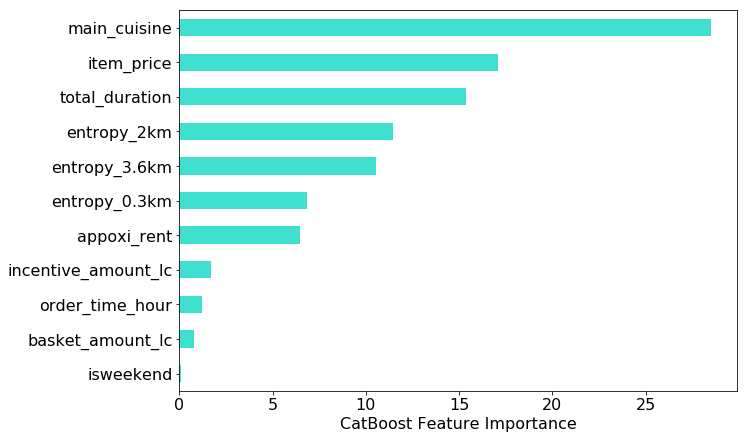

In [13]:
%%time

import matplotlib.pylab as plt
from matplotlib import pyplot

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(10,7))
df_feature_importance = pd.DataFrame({'feature_importance': regressor.get_feature_importance(train_dataset), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

df_feature_importance[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(
    x='feature_names', y='feature_importance',color='turquoise',ax=ax)
plt.xlabel("CatBoost Feature Importance")
ax.get_legend().remove()
ax.set(ylabel=None)

## PDP

2024-05-28 13:11:04.798809 *************** Start running PDP ***************
2024-05-28 13:41:21.520906 *************** Done running PDP ***************
CPU times: user 3h 20min 30s, sys: 12min 10s, total: 3h 32min 41s
Wall time: 30min 16s


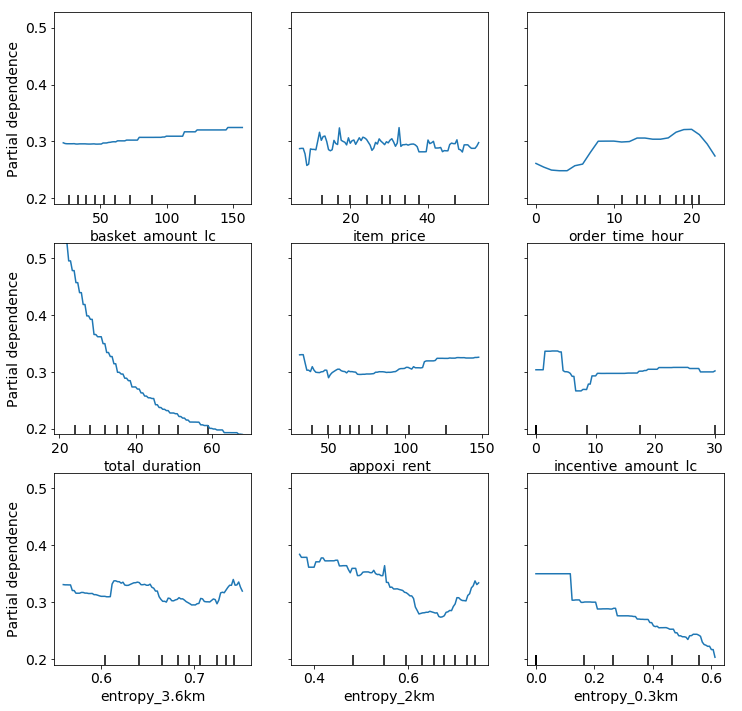

In [62]:
%%time 
# takes ~ 14min in total
print(datetime.datetime.now(),'*************** Start running PDP ***************')
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, 12))
tree_disp = PartialDependenceDisplay.from_estimator(
    regressor, X, ['basket_amount_lc','item_price','order_time_hour','total_duration',
                            'appoxi_rent','incentive_amount_lc','entropy_3.6km','entropy_2km','entropy_0.3km'
                            ], ax=ax)
print(datetime.datetime.now(),'*************** Done running PDP ***************')

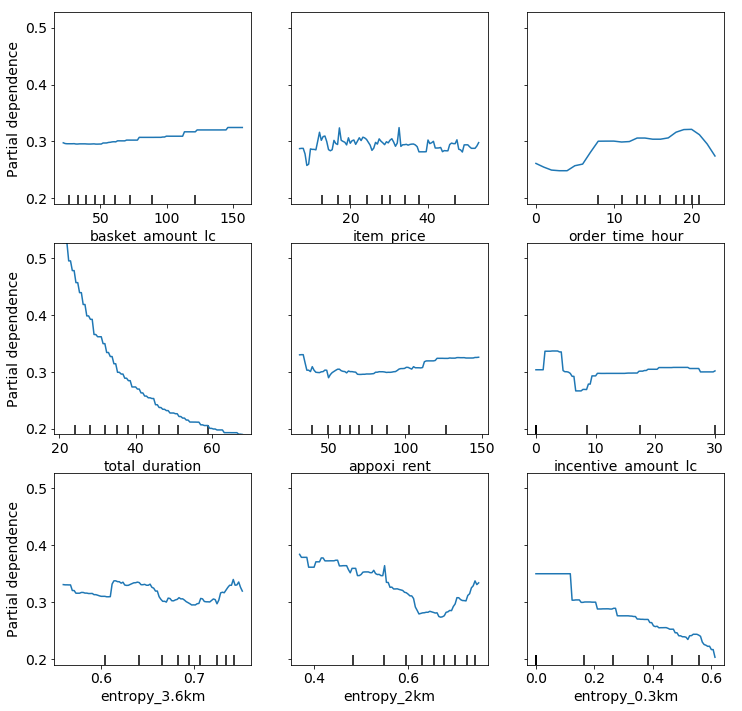

In [67]:
#resize figure
plt.rcParams.update({'font.size': 14})
fig2, ax2 = plt.subplots(figsize=(12, 12))
tree_disp.plot(ax=ax2)

2024-05-28 21:46:26.973461 *************** Start running PDP ***************


TypeError: from_estimator() got an unexpected keyword argument 'categorical_features'

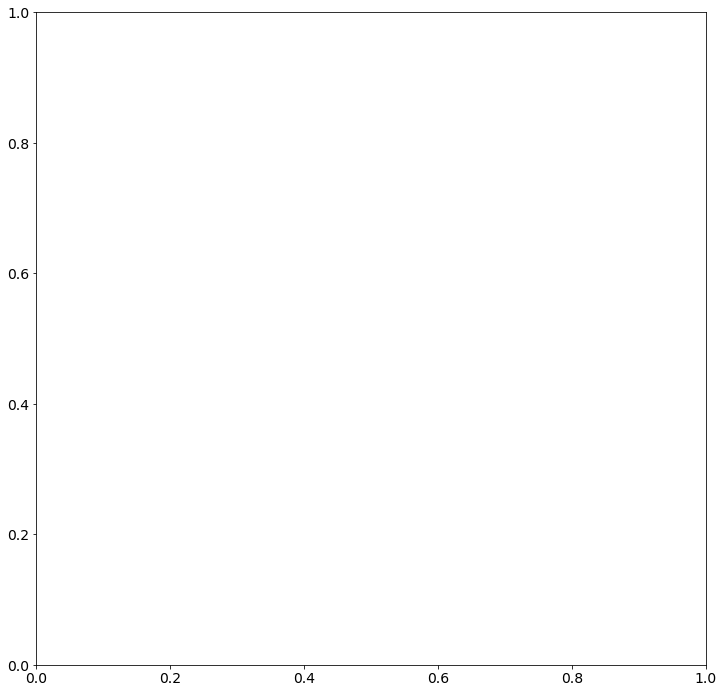

In [29]:
%%time 
# takes ~ 14min in total
print(datetime.datetime.now(),'*************** Start running PDP ***************')
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, 12))
tree_disp = PartialDependenceDisplay.from_estimator(
    regressor, X, features=['main_cuisine'], categorical_features=['main_cuisine'], ax=ax)
print(datetime.datetime.now(),'*************** Done running PDP ***************')

## SHAP

In [65]:
%%time

import shap

explainer = shap.TreeExplainer(regressor)
shap_values = explainer(X)

CPU times: user 11min 8s, sys: 9.94 s, total: 11min 18s
Wall time: 1min


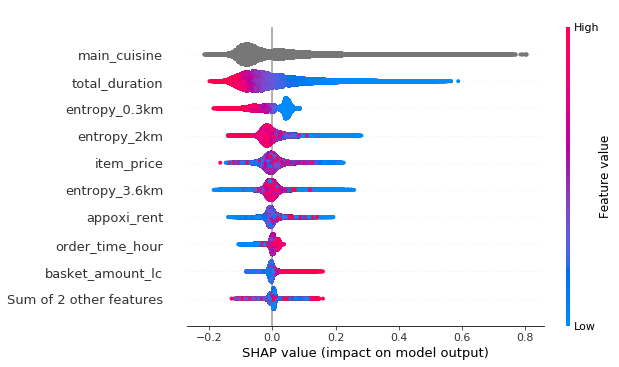

CPU times: user 5min 5s, sys: 6.27 s, total: 5min 11s
Wall time: 5min 9s


In [66]:
%%time
shap.plots.beeswarm(shap_values)

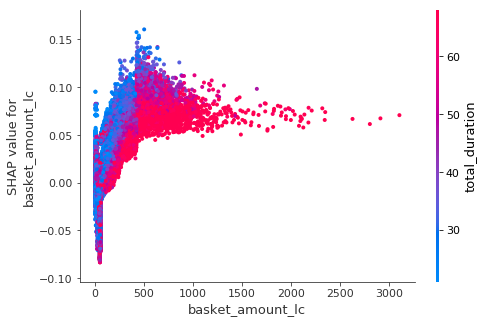

CPU times: user 30 s, sys: 1.24 s, total: 31.3 s
Wall time: 30.7 s


In [68]:
%%time
shap.dependence_plot(0, shap_values.values, X)
#interaction_index“auto”, pick the strongest interaction

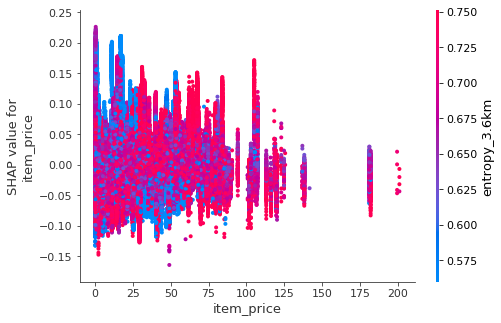

CPU times: user 29.7 s, sys: 1.42 s, total: 31.1 s
Wall time: 30.6 s


In [69]:
%%time
shap.dependence_plot(1, shap_values.values, X)

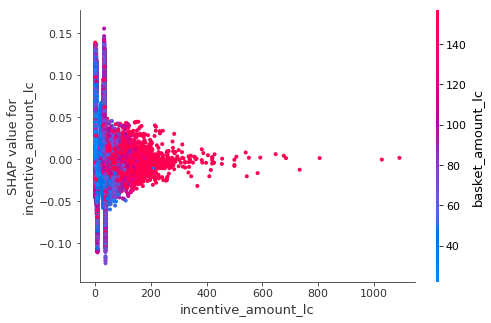

CPU times: user 29.4 s, sys: 1.36 s, total: 30.8 s
Wall time: 30.2 s


In [73]:
%%time
shap.dependence_plot('incentive_amount_lc', shap_values.values, X) 

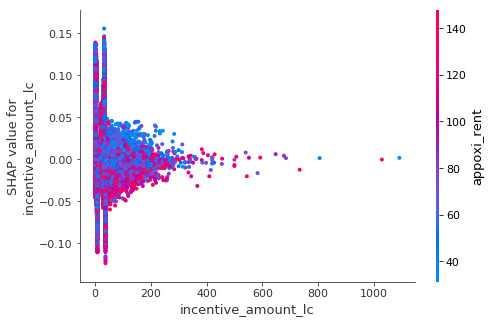

CPU times: user 29.6 s, sys: 872 ms, total: 30.4 s
Wall time: 29.9 s


In [74]:
%%time
shap.dependence_plot('incentive_amount_lc', shap_values.values, X ,interaction_index='appoxi_rent') 

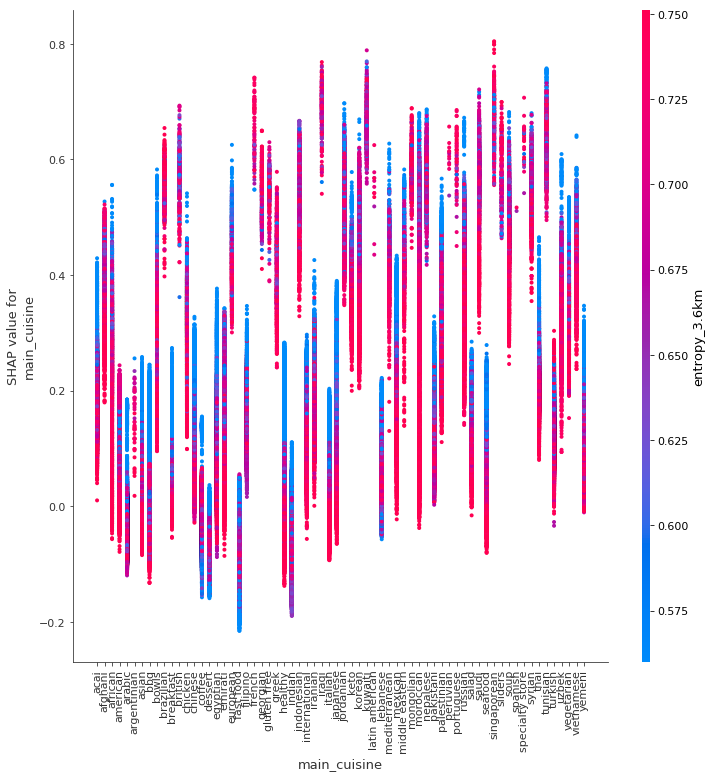

CPU times: user 36.5 s, sys: 1.13 s, total: 37.6 s
Wall time: 36.8 s


In [79]:
%%time

plt.rcParams.update({'font.size': 14})
fig_cuisine, ax_cuisine = plt.subplots(figsize=(12, 12))
shap.dependence_plot('main_cuisine', shap_values.values, X,ax=ax_cuisine) 